In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv("/content/sample_data/Australian Vehicle Prices.csv")

In [3]:
df.head()

,Brand,Year,Model,Car/Suv,Title,UsedOrNew,Transmission,Engine,DriveType,FuelType,FuelConsumption,Kilometres,ColourExtInt,Location,CylindersinEngine,BodyType,Doors,Seats,Price
0,Ssangyong,2022.0,Rexton,Sutherland Isuzu Ute,2022 Ssangyong Rexton Ultimate (awd),DEMO,Automatic,"4 cyl, 2.2 L",AWD,Diesel,8.7 L / 100 km,5595,White / Black,"Caringbah, NSW",4 cyl,SUV,4 Doors,7 Seats,51990
1,MG,2022.0,MG3,Hatchback,2022 MG MG3 Auto Excite (with Navigation),USED,Automatic,"4 cyl, 1.5 L",Front,Premium,6.7 L / 100 km,16,Black / Black,"Brookvale, NSW",4 cyl,Hatchback,5 Doors,5 Seats,19990
2,BMW,2022.0,430I,Coupe,2022 BMW 430I M Sport,USED,Automatic,"4 cyl, 2 L",Rear,Premium,6.6 L / 100 km,8472,Grey / White,"Sylvania, NSW",4 cyl,Coupe,2 Doors,4 Seats,108988
3,Mercedes-Benz,2011.0,E500,Coupe,2011 Mercedes-Benz E500 Elegance,USED,Automatic,"8 cyl, 5.5 L",Rear,Premium,11 L / 100 km,136517,White / Brown,"Mount Druitt, NSW",8 cyl,Coupe,2 Doors,4 Seats,32990
4,Renault,2022.0,Arkana,SUV,2022 Renault Arkana Intens,USED,Automatic,"4 cyl, 1.3 L",Front,Unleaded,6 L / 100 km,1035,Grey / Black,"Castle Hill, NSW",4 cyl,SUV,4 Doors,5 Seats,34990


In [4]:
df.shape

(16734, 19)

In [5]:
df.isna().sum()

,0
Brand,1
Year,1
Model,1
Car/Suv,28
Title,1
UsedOrNew,1
Transmission,1
Engine,1
DriveType,1
FuelType,1


### Drop na rows

In [6]:
df.dropna(axis=0,inplace=True)

In [7]:
df.shape

(14586, 19)

### Convert columns to relevant data types

In [8]:
# kilometer to integer
# Drop rows with missing or empty 'Price' values
df = df[df['Kilometres'].notna()]  # Remove NaNs
df = df[df['Kilometres'].astype(str).str.strip() != '']  # Remove empty strings

# Now clean and convert
df['Kilometres'] = (
    df['Kilometres']
    .astype(str)
    .str.replace(',', '', regex=False)         # Remove commas
    .str.replace(r'[^0-9]', '', regex=True)    # Remove non-numeric characters
)

# Drop rows where price is still empty after cleanup
df = df[df['Kilometres'].str.strip() != '']

# Final conversion
df['Kilometres'] = df['Kilometres'].astype(int)
# doors and seats to integers

df['doors_int'] = df['Doors'].str.extract(r'(\d+)').astype(int)
df['seats_int'] = df['Seats'].str.extract(r'(\d+)').astype(int)

#----------------------------------------------------------------------------

# litres per 100 km
df['LitresPer100km'] = df['FuelConsumption'].str.extract(r'([\d.]+)').astype(float)

#-------------------------------------------------------------------------------
# used or new to dummy variables

df["used_0_new_1"]=df['UsedOrNew'].apply(lambda x:1 if x=="New" else 0)

#--------------------------------------------------------------------------------
#transmission to automatic or manual
df['transmission_auto'] = df['Transmission'].apply(
    lambda x: 1 if re.search(r'(Automatic)', x, re.IGNORECASE) else 0
)

#-------------------------------------------------------------------------------
# add age of car
df['age']=2023-df['Year']

#-------------------------------------------------------------------------------------

# convert 100+ colors to 9 standard colors

df['color_primary'] = df['ColourExtInt'].str.split('/').str[0].str.strip()


def map_to_standard_color(color_name):
    name = color_name.lower()

    if 'black' in name or 'obsidian' in name or 'noctis' in name or 'onyx' in name or 'ebony' in name or 'nero' in name:
        return 'black'
    elif 'white' in name or 'frost' in name or 'pearl' in name or 'ivory' in name or 'snow' in name:
        return 'white'
    elif 'gray' in name or 'grey' in name or 'graphite' in name or 'slate' in name or 'charcoal' in name:
        return 'gray'
    elif 'silver' in name or 'steel' in name or 'metallic' in name or 'iridium' in name:
        return 'silver'
    elif 'red' in name or 'crimson' in name or 'maroon' in name or 'garnet' in name or 'burgundy' in name or 'cherry' in name:
        return 'red'
    else:
        return 'others'
# apply the std colors to the color_primary column
df['std_color'] = df['color_primary'].apply(map_to_standard_color)

color_order = ['others', 'black', 'white', 'gray', 'silver','red']
df['std_color'] = pd.Categorical(df['std_color'], categories=color_order, ordered=True)


# dummy variables for color
dummies_colors=pd.get_dummies(df['std_color'],prefix='color',drop_first=True,dtype=int)
df=pd.concat([df,dummies_colors],axis=1)

#----------------------------------------------------------------------------------------

# convert fuel to 4 categories and create dummy variables
def bucket_fuel_type(fuel):
    fuel = str(fuel).lower().strip()

    if any(keyword in fuel for keyword in ['gasoline', 'unleaded', 'premium']):
        return "Gasoline"
    elif "Diesel" in fuel:
        return "Diesel"
    elif "Electric" in fuel:
        return "Electric"
    elif "hybrid" in fuel:
        return "Hybrid"
    else:
        return "Others"

df['fuel_bucket'] = df['FuelType'].apply(bucket_fuel_type)

fuel_order = ['Others', 'Gasoline', 'Diesel', 'Electric', 'Hybrid']
df['fuel_bucket'] = pd.Categorical(df['fuel_bucket'], categories=fuel_order, ordered=True)

# create dummies for fuel

dummies_fuel_bucket=pd.get_dummies(df['fuel_bucket'],prefix='fuel_cat',drop_first=True,dtype=int)
df=pd.concat([df,dummies_fuel_bucket],axis=1)

### Removing empty values in Price column and converting to Integer

### Bucket Brands based on Price thresholds

In [9]:
# Step 1: Clean and convert 'Price' to integer (assuming it's done already)
# Drop rows with missing or empty 'Price' values
df = df[df['Price'].notna()]  # Remove NaNs
df = df[df['Price'].astype(str).str.strip() != '']  # Remove empty strings

# Now clean and convert
df['Price'] = (
    df['Price']
    .astype(str)
    .str.replace(',', '', regex=False)         # Remove commas
    .str.replace(r'[^0-9]', '', regex=True)    # Remove non-numeric characters
)

# Drop rows where price is still empty after cleanup
df = df[df['Price'].str.strip() != '']

# Final conversion
df['Price'] = df['Price'].astype(int)


# Step 2: Compute median price per brand
brand_medians = df.groupby('Brand')['Price'].median().sort_values(ascending=False)

# Step 3: Create quantile thresholds
q1 = brand_medians.quantile(0.3)
q2 = brand_medians.quantile(0.6)
q3 = brand_medians.quantile(0.9)

# Step 4: Define a function to map brands to buckets
def map_price_bucket(brand):
    price = brand_medians.get(brand, 0)
    if price >= q3:
        return 'Ultra Luxury'
    elif price >= q2:
        return 'Luxury'
    elif price >= q1:
        return 'Premium'
    else:
        return 'Economy'

# Step 5: Apply to your dataframe
df['Brand_Bucket'] = df['Brand'].apply(map_price_bucket)


# Step 6: Convert brand_buckets to dummy variables
dummies_brand=pd.get_dummies(df['Brand_Bucket'],prefix='brand_cat',drop_first=False,dtype=int)
df=pd.concat([df,dummies_brand],axis=1)

# creating brand dictionary
brand_dict = df.groupby('Brand_Bucket')['Brand'].unique().to_dict()
for bucket, brands in brand_dict.items():
    print(f"{bucket}: {list(brands)}")


# Create brand → model mapping
brand_model_dict = (
    df.groupby('Brand')['Model']
    .unique()  # get unique models for each brand
    .apply(list)  # convert numpy array to list
    .to_dict()  # convert Series to dictionary
)

Economy: ['Nissan', 'Honda', 'Hyundai', 'Holden', 'Suzuki', 'Peugeot', 'Fiat', 'Citroen', 'Foton', 'Alfa', 'Dodge', 'Great', 'Opel', 'Infiniti', 'Tata', 'Daewoo', 'Saab', 'Proton', 'Smart']
Luxury: ['Ssangyong', 'Mercedes-Benz', 'Land', 'Audi', 'Porsche', 'Isuzu', 'Lexus', 'Jaguar', 'Skoda', 'HSV', 'Mahindra', 'Maserati', 'GWM', 'Ram', 'Tesla', 'Genesis', 'Cupra', 'FPV', 'BYD']
Premium: ['MG', 'BMW', 'Renault', 'Toyota', 'Volkswagen', 'Ford', 'Mitsubishi', 'Subaru', 'Jeep', 'Volvo', 'Mazda', 'Abarth', 'Kia', 'Mini', 'Haval', 'LDV', 'Chrysler', 'Iveco', 'Chery']
Ultra Luxury: ['Rolls-Royce', 'Bentley', 'Ferrari', 'Chevrolet', 'Lamborghini', 'McLaren', 'Aston']


Extracting Cylinders and Engine capacity as integer columns

In [10]:
# Example column name: 'Engine_Info' = "4 cyl, 2.2 L"
df[['cylinders', 'engine_l']] = df['Engine'].str.extract(r'(\d+)\s*cyl.*?([\d\.]+)\s*L')

# Convert to integers / floats
df['cylinders'] = df['cylinders'].astype('Int64')
df['engine_l'] = df['engine_l'].astype(float)


Drop Brands with less than 50 data points

In [11]:
brand_counts = df['Brand'].value_counts()
valid_brands = brand_counts[brand_counts >= 50].index
df = df[df['Brand'].isin(valid_brands)]

Adjusting for class imbalance in luxury and super luxury segments

In [12]:
df['make_model']=df['Brand'].astype(str)+' '+df['Model'].astype(str)

In [13]:
df['make_model']

,make_model
1,MG MG3
2,BMW 430I
3,Mercedes-Benz E500
4,Renault Arkana
6,Land Rover
...,...
16727,Hyundai I30
16728,Nissan Qashqai
16731,Suzuki Vitara
16732,Mercedes-Benz GLC250


In [14]:
# Median price per make_model
make_model_stats = df.groupby('make_model')['Price'].median().to_dict()

In [15]:

# Assuming 'brand_bucket' already exists
# And 'make_model' column already exists
df['make_model'] = df['Brand'] + " " + df['Model']

# Median, min, max price per make_model
make_model_stats = df.groupby('make_model')['Price'].agg(['median', 'min', 'max']).to_dict('index')

# Noise mapping based on brand_bucket
noise_map = {
    3: 0.10,  # Luxury
    2: 0.07,  # Premium
    1: 0.05   # Economy
}

threshold = 20  # Minimum rows per make_model
df_balanced = df.copy()

for mm, count in df['make_model'].value_counts().items():
    if count < threshold:
        extra_needed = threshold - count

        # Get stats for this make_model
        base_price = make_model_stats[mm]['median']
        min_price = make_model_stats[mm]['min']
        max_price = make_model_stats[mm]['max']

        # Get original rows for feature values
        rows = df[df['make_model'] == mm]

        # Sample with replacement
        sampled_rows = rows.sample(extra_needed, replace=True).reset_index(drop=True)

        # Get bucket for noise level
        brand_type = sampled_rows['Brand_Bucket'].iloc[0]
        noise_factor = noise_map.get(brand_type, 0.05)  # default ±5%

        # Apply noise and clamp within min–max
        noisy_prices = base_price * (
            1 + np.random.uniform(-noise_factor, noise_factor, size=extra_needed)
        )
        noisy_prices = np.clip(noisy_prices, min_price, max_price)

        sampled_rows['Price'] = noisy_prices

        # Append
        df_balanced = pd.concat([df_balanced, sampled_rows], ignore_index=True)

print(f"Original size: {df.shape[0]} → Balanced size: {df_balanced.shape[0]}")

Original size: 14037 → Balanced size: 20128


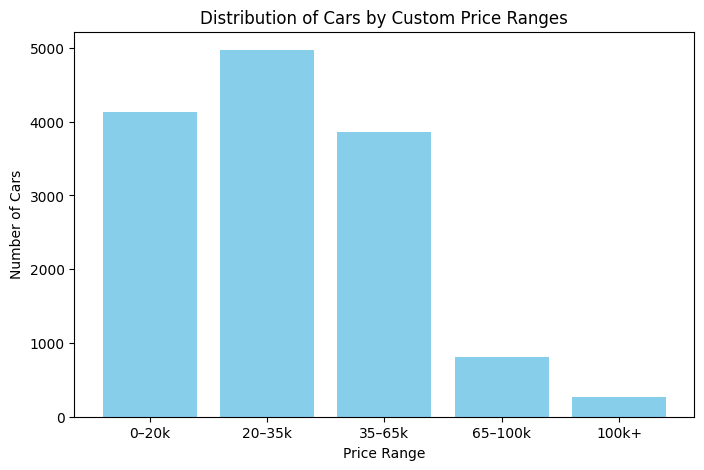

In [16]:
# Define bin edges (upper bound inclusive by default except last bin)
bin_edges = [0,20000, 35000, 65000,100000, df['Price'].max()]

# Define labels for the bins
bin_labels = ['0–20k', '20–35k', '35–65k', '65–100k', '100k+']

# Create bins
df['price_bin'] = pd.cut(df['Price'], bins=bin_edges, labels=bin_labels, include_lowest=True)

# Count distribution
bin_summary = df['price_bin'].value_counts().sort_index().reset_index()
bin_summary.columns = ['Price Range', 'Count']

# Plot
plt.figure(figsize=(8,5))
plt.bar(bin_summary['Price Range'].astype(str), bin_summary['Count'], color='skyblue')
plt.xlabel("Price Range")
plt.ylabel("Number of Cars")
plt.title("Distribution of Cars by Custom Price Ranges")
plt.show()

In [17]:
# Define price ranges and labels
price_bins = [0, 20000, 35000, 65000, 100000, float('inf')]
price_labels = ['budget', 'economy', 'premium', 'luxury', 'super_luxury']

# Calculate median price for each make_model
make_model_median = df.groupby('make_model')['Price'].median().reset_index()

# Bin them based on median price
make_model_median['price_segment'] = pd.cut(make_model_median['Price'],
                                            bins=price_bins,
                                            labels=price_labels,
                                            include_lowest=True)

# Create dictionary mapping make_model → segment
make_model_segment_dict = dict(zip(make_model_median['make_model'],
                                   make_model_median['price_segment']))

# Apply mapping to main df
df['make_model_segment'] = df['make_model'].map(make_model_segment_dict)

# Check distribution
print(df['make_model_segment'].value_counts())


make_model_segment
economy         6468
premium         4311
budget          2918
luxury           221
super_luxury     119
Name: count, dtype: int64


In [24]:
df.columns

Index(['Brand', 'Year', 'Model', 'Car/Suv', 'Title', 'UsedOrNew',
       'Transmission', 'Engine', 'DriveType', 'FuelType', 'FuelConsumption',
       'Kilometres', 'ColourExtInt', 'Location', 'CylindersinEngine',
       'BodyType', 'Doors', 'Seats', 'Price', 'doors_int', 'seats_int',
       'LitresPer100km', 'used_0_new_1', 'transmission_auto', 'age',
       'color_primary', 'std_color', 'color_black', 'color_white',
       'color_gray', 'color_silver', 'color_red', 'fuel_bucket',
       'fuel_cat_Gasoline', 'fuel_cat_Diesel', 'fuel_cat_Electric',
       'fuel_cat_Hybrid', 'Brand_Bucket', 'brand_cat_Economy',
       'brand_cat_Luxury', 'brand_cat_Premium', 'brand_cat_Ultra Luxury',
       'cylinders', 'engine_l', 'make_model', 'price_bin',
       'make_model_segment'],
      dtype='object')

In [ ]:
make_model_segment_dict

{'Audi A1': 'economy',
 'Audi A3': 'economy',
 'Audi A4': 'economy',
 'Audi A5': 'premium',
 'Audi A6': 'economy',
 'Audi A7': 'premium',
 'Audi A8': 'economy',
 'Audi E-Tron': 'super_luxury',
 'Audi Q2': 'premium',
 'Audi Q3': 'premium',
 'Audi Q5': 'premium',
 'Audi Q7': 'premium',
 'Audi Q8': 'luxury',
 'Audi R8': 'super_luxury',
 'Audi RS': 'super_luxury',
 'Audi RS3': 'premium',
 'Audi RS4': 'super_luxury',
 'Audi RS5': 'super_luxury',
 'Audi RS6': 'super_luxury',
 'Audi S3': 'premium',
 'Audi S4': 'luxury',
 'Audi S5': 'premium',
 'Audi SQ2': 'luxury',
 'Audi SQ5': 'premium',
 'Audi SQ7': 'super_luxury',
 'Audi SQ8': 'super_luxury',
 'Audi TT': 'premium',
 'BMW 116I': 'budget',
 'BMW 118D': 'budget',
 'BMW 118I': 'economy',
 'BMW 120D': 'budget',
 'BMW 120I': 'economy',
 'BMW 125I': 'budget',
 'BMW 128TI': 'premium',
 'BMW 135I': 'budget',
 'BMW 2': 'luxury',
 'BMW 218D': 'economy',
 'BMW 218I': 'economy',
 'BMW 220D': 'economy',
 'BMW 220I': 'economy',
 'BMW 225I': 'economy',
 '

In [ ]:
from collections import defaultdict

# Create groups
make_model_groups = defaultdict(list)

for model, category in make_model_segment_dict.items():
    make_model_groups[category].append(model)

# Example output
for category, models in make_model_groups.items():
    print(f"{category} ({len(models)} cars):")
    print(models[:10], "...")

economy (140 cars):
['Audi A1', 'Audi A3', 'Audi A4', 'Audi A6', 'Audi A8', 'BMW 118I', 'BMW 120I', 'BMW 218D', 'BMW 218I', 'BMW 220D'] ...
premium (139 cars):
['Audi A5', 'Audi A7', 'Audi Q2', 'Audi Q3', 'Audi Q5', 'Audi Q7', 'Audi RS3', 'Audi S3', 'Audi S5', 'Audi SQ5'] ...
super_luxury (45 cars):
['Audi E-Tron', 'Audi R8', 'Audi RS', 'Audi RS4', 'Audi RS5', 'Audi RS6', 'Audi SQ7', 'Audi SQ8', 'BMW 5', 'BMW I4'] ...
luxury (54 cars):
['Audi Q8', 'Audi S4', 'Audi SQ2', 'BMW 2', 'BMW 330I', 'BMW 730D', 'BMW 740I', 'BMW M2', 'BMW M3', 'BMW M340I'] ...
budget (161 cars):
['BMW 116I', 'BMW 118D', 'BMW 120D', 'BMW 125I', 'BMW 135I', 'BMW 316I', 'BMW 318I', 'BMW 320CI', 'BMW 320D', 'BMW 320I'] ...


In [ ]:
with open("car_groups.txt", "w") as f:
    for category, models in make_model_groups.items():
        f.write(f"{category} ({len(models)} cars):\n")
        f.write(", ".join(models) + "\n\n")

Dropping Luxury & Super Luxury category

In [ ]:
df=df[df['make_model_segment']!='super_luxury']
df=df[df['make_model_segment']!='luxury']

### Car Category (Sedan / SUV / Hatchback)

In [ ]:
known_categories = [
    'SUV', 'Hatchback', 'Sedan',
    'Wagon', 'Coupe', 'Convertible'
]


# Step 2: Apply mapping logic
df['CarBodyType_Cleaned'] = df['Car/Suv'].apply(lambda x: x if x in known_categories else 'Other')


### Understanding outliers in Price, Kilometers and LitresPer100Km

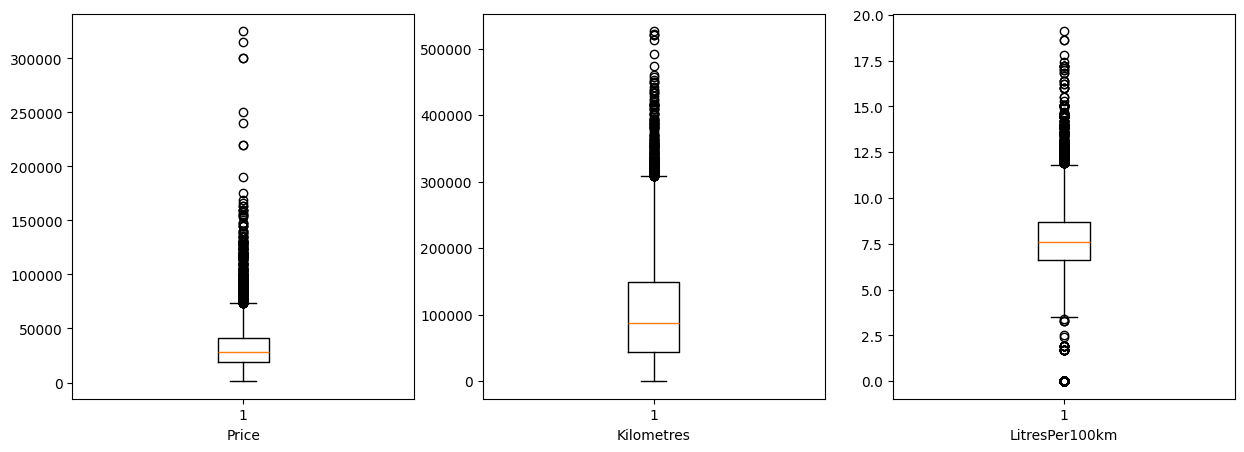

In [ ]:
fig,axes=plt.subplots(1,3,figsize=(15,5))
axes[0].boxplot(df['Price'])
axes[0].set_xlabel('Price')
axes[1].boxplot(df['Kilometres'])
axes[1].set_xlabel('Kilometres')
axes[2].boxplot(df['LitresPer100km'])
axes[2].set_xlabel('LitresPer100km')
plt.show()

Dropping Price > $100k and Year < 2005

In [ ]:
df=df[(df['Price']<100000)&(df['Price']>10000)]
df=df[(df['LitresPer100km']<20)&(df['LitresPer100km']>4)]
df.drop(df[df['Year'] < 2005].index, inplace=True)
df=df[(df['Kilometres']<200000)&(df['Kilometres']>1000)]
df=df[df['CarBodyType_Cleaned']!="Coupe"]
df=df[df['CarBodyType_Cleaned']!="Convertible"]

### Distribution of data year wise

In [ ]:
year_distribution=df.groupby('Year')['Year'].count()

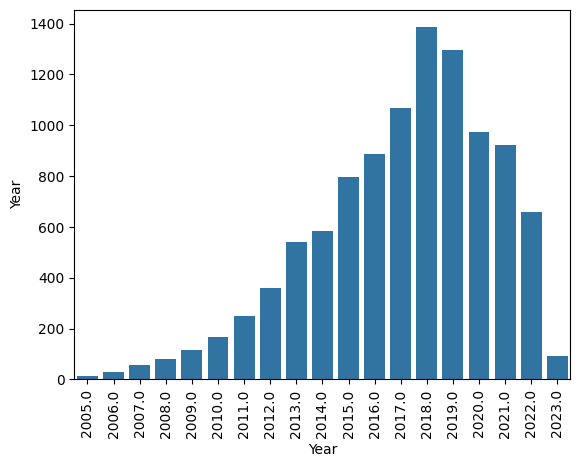

In [ ]:
sns.barplot(year_distribution)
plt.xlabel('Year')
plt.xticks(rotation=90)
plt.show()

### Capping outliers and dropping data for years prior to 2000 (older than 25 years)

In [ ]:
def outlier_treatment(col,factor):
  q1=df[col].quantile(0.15)
  q3=df[col].quantile(0.85)
  IQR=q3-q1
  lower_limit=q1-factor*IQR
  upper_limit=q3+factor*IQR
  df[col] = df[col].astype(float)
  df.loc[(df[col]<lower_limit),col]=lower_limit
  df.loc[(df[col]>upper_limit),col]=upper_limit

In [ ]:
outlier_treatment('Price',1.5)
outlier_treatment('Kilometres',1.5)
outlier_treatment('LitresPer100km',1.5)
outlier_treatment('age',1.5)

In [ ]:
df['log_price'] = np.log1p(df['Price'])
df['age_squared'] = df['age']**2

### Checking the outliers plot again

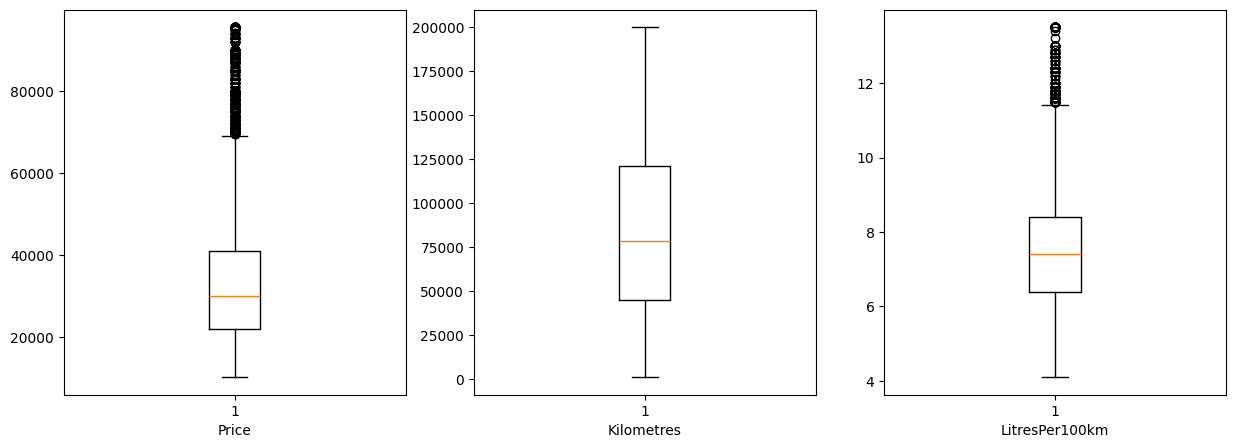

In [ ]:
fig,axes=plt.subplots(1,3,figsize=(15,5))
axes[0].boxplot(df['Price'])
axes[0].set_xlabel('Price')
axes[1].boxplot(df['Kilometres'])
axes[1].set_xlabel('Kilometres')
axes[2].boxplot(df['LitresPer100km'])
axes[2].set_xlabel('LitresPer100km')
plt.show()

In [ ]:
df.describe()

,Year,Kilometres,Price,doors_int,seats_int,LitresPer100km,used_0_new_1,transmission_auto,age,color_black,...,fuel_cat_Electric,fuel_cat_Hybrid,brand_cat_Economy,brand_cat_Luxury,brand_cat_Premium,brand_cat_Ultra Luxury,cylinders,engine_l,log_price,age_squared
count,10262.000000,10262.000000,10262.000000,10262.000000,10262.000000,10262.000000,10262.0,10262.000000,10262.000000,10262.000000,...,10262.0,10262.000000,10262.000000,10262.000000,10262.000000,10262.0,10262.0,10262.000000,10262.000000,10262.000000
mean,2017.086338,84385.811635,33177.220888,4.097837,5.167609,7.545215,0.0,0.909959,5.913662,0.105438,...,0.0,0.043266,0.262424,0.115182,0.622393,0.0,4.316995,2.314149,10.300110,46.536348
std,3.400893,50867.119889,16142.596662,0.575104,1.013779,1.660309,0.0,0.286254,3.400893,0.307131,...,0.0,0.203466,0.439974,0.319257,0.484812,0.0,0.852533,0.750528,0.468275,50.581613
min,2005.000000,1002.000000,10200.000000,2.000000,2.000000,4.100000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,3.0,1.000000,9.230241,0.000000
25%,2015.000000,45071.000000,21950.000000,4.000000,5.000000,6.400000,0.0,1.000000,3.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,4.0,2.000000,9.996568,9.000000
50%,2018.000000,78374.500000,29900.000000,4.000000,5.000000,7.400000,0.0,1.000000,5.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,1.000000,0.0,4.0,2.000000,10.305647,25.000000
75%,2020.000000,120964.250000,40888.000000,4.000000,5.000000,8.400000,0.0,1.000000,8.000000,0.000000,...,0.0,0.000000,1.000000,0.000000,1.000000,0.0,4.0,2.500000,10.618616,64.000000
max,2023.000000,199987.000000,95512.050000,5.000000,14.000000,13.500000,0.0,1.000000,18.000000,1.000000,...,0.0,1.000000,1.000000,1.000000,1.000000,0.0,8.0,6.400000,11.467018,324.000000


In [ ]:
#corr_matrix=df.corr(numeric_only=True)

In [ ]:
#sns.heatmap(corr_matrix,annot=True,cmap='coolwarm',fmt='.2f')
#plt.show()

In [ ]:
df=pd.concat([df,pd.get_dummies(df['CarBodyType_Cleaned'],prefix='Body_type',drop_first=True,dtype=int)],axis=1)
df=pd.concat([df,pd.get_dummies(df['make_model_segment'],prefix='Make_Model_cat',drop_first=True,dtype=int)],axis=1)
df.head(5)

,Brand,Year,Model,Car/Suv,Title,UsedOrNew,Transmission,Engine,DriveType,FuelType,...,make_model_segment,CarBodyType_Cleaned,log_price,age_squared,Body_type_Other,Body_type_SUV,Body_type_Sedan,Body_type_Wagon,Make_Model_cat_economy,Make_Model_cat_premium
4,Renault,2022.0,Arkana,SUV,2022 Renault Arkana Intens,USED,Automatic,"4 cyl, 1.3 L",Front,Unleaded,...,premium,SUV,10.462846,1.0,0,1,0,0,0,1
6,Land,2017.0,Rover,SUV,2017 Land Rover Range Rover Evoque TD4 180 HSE...,USED,Automatic,"4 cyl, 2 L",AWD,Diesel,...,premium,SUV,11.039412,36.0,0,1,0,0,0,1
9,Honda,2014.0,Jazz,Hatchback,2014 Honda Jazz Hybrid,USED,Automatic,"4 cyl, 1.3 L",Front,Hybrid,...,budget,Hatchback,9.792612,81.0,0,0,0,0,0,0
11,Toyota,2018.0,HiAce,Commercial,2018 Toyota HiAce LWB,USED,Automatic,"4 cyl, 2.7 L",Rear,Unleaded,...,economy,Other,10.645425,25.0,1,0,0,0,1,0
15,Volkswagen,2012.0,Golf,Hatchback,2012 Volkswagen Golf 90 TSI Trendline,USED,Automatic,"4 cyl, 1.4 L",Front,Premium,...,economy,Hatchback,9.615805,121.0,0,0,0,0,1,0


### Model Training and Evaluation

In [ ]:
X=df.select_dtypes(include=['int','float']).drop(columns=['Price','Year','age','log_price'])
y=df['log_price']

In [ ]:
X.columns

Index(['Kilometres', 'doors_int', 'seats_int', 'LitresPer100km',
       'used_0_new_1', 'transmission_auto', 'color_black', 'color_white',
       'color_gray', 'color_silver', 'color_red', 'fuel_cat_Gasoline',
       'fuel_cat_Diesel', 'fuel_cat_Electric', 'fuel_cat_Hybrid',
       'brand_cat_Economy', 'brand_cat_Luxury', 'brand_cat_Premium',
       'brand_cat_Ultra Luxury', 'cylinders', 'engine_l', 'age_squared',
       'Body_type_Other', 'Body_type_SUV', 'Body_type_Sedan',
       'Body_type_Wagon', 'Make_Model_cat_economy', 'Make_Model_cat_premium'],
      dtype='object')

In [ ]:
X.head()

,Kilometres,doors_int,seats_int,LitresPer100km,used_0_new_1,transmission_auto,color_black,color_white,color_gray,color_silver,...,brand_cat_Ultra Luxury,cylinders,engine_l,age_squared,Body_type_Other,Body_type_SUV,Body_type_Sedan,Body_type_Wagon,Make_Model_cat_economy,Make_Model_cat_premium
4,1035.0,4,5,6.0,0,1,0,0,1,0,...,0,4,1.3,1.0,0,1,0,0,0,1
6,67662.0,2,4,5.1,0,1,0,1,0,0,...,0,4,2.0,36.0,0,1,0,0,0,1
9,38229.0,5,5,4.5,0,1,0,0,0,0,...,0,4,1.3,81.0,0,0,0,0,0,0
11,16324.0,4,2,9.8,0,1,0,1,0,0,...,0,4,2.7,25.0,1,0,0,0,1,0
15,55676.0,5,5,6.2,0,1,0,1,0,0,...,0,4,1.4,121.0,0,0,0,0,1,0


In [ ]:
y.head()

,log_price
4,10.462846
6,11.039412
9,9.792612
11,10.645425
15,9.615805


### Building the model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_squared_error


In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=52)

In [ ]:
lm=LinearRegression()
lm.fit(X_train,y_train)
# predict
y_pred=lm.predict(X_test)


In [ ]:
# calculate performance
mse=mean_squared_error(y_test,y_pred)
r2=r2_score(y_test,y_pred)

print(f'MSE:{mse:.4f}')
print(f'R2:{r2:.4f}')

MSE:0.0459
R2:0.7895


### Trying Lasso regularization to remove redundant variables

In [ ]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [ ]:
lasso_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # scales variables to mean=0, std=1
    ('lasso', LassoCV(cv=5, random_state=52))
])


In [ ]:
lasso_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('lasso', LassoCV(cv=5, random_state=52))])

In [ ]:
y_pred = lasso_pipeline.predict(X_test)
print("R² Score:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))


R² Score: 0.7895419923501433
RMSE: 0.214300736612674


In [ ]:
# Extract the fitted Lasso model
lasso_model = lasso_pipeline.named_steps['lasso']
selected_features = X_train.columns[lasso_model.coef_ != 0]

# Coefficients and feature names
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lasso_model.coef_
})
# Only non-zero coefficients
print(coef_df[coef_df['Coefficient'] != 0].sort_values(by='Coefficient', ascending=False))


                   Feature  Coefficient
27  Make_Model_cat_premium     0.170475
20                engine_l     0.118466
26  Make_Model_cat_economy     0.088870
22         Body_type_Other     0.055102
16        brand_cat_Luxury     0.048212
23           Body_type_SUV     0.038635
24         Body_type_Sedan     0.029396
19               cylinders     0.025528
2                seats_int     0.019277
1                doors_int     0.018501
3           LitresPer100km     0.017358
25         Body_type_Wagon     0.013898
14         fuel_cat_Hybrid     0.005901
6              color_black     0.005202
8               color_gray     0.002851
10               color_red    -0.004484
5        transmission_auto    -0.005198
9             color_silver    -0.010169
7              color_white    -0.012888
15       brand_cat_Economy    -0.021952
11       fuel_cat_Gasoline    -0.084371
0               Kilometres    -0.169593
21             age_squared    -0.171702


In [ ]:
selected_features

Index(['Kilometres', 'doors_int', 'seats_int', 'LitresPer100km',
       'transmission_auto', 'color_black', 'color_white', 'color_gray',
       'color_silver', 'color_red', 'fuel_cat_Gasoline', 'fuel_cat_Hybrid',
       'brand_cat_Economy', 'brand_cat_Luxury', 'cylinders', 'engine_l',
       'age_squared', 'Body_type_Other', 'Body_type_SUV', 'Body_type_Sedan',
       'Body_type_Wagon', 'Make_Model_cat_economy', 'Make_Model_cat_premium'],
      dtype='object')

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf_lasso = RandomForestRegressor(n_estimators=100, random_state=52)
rf_lasso.fit(X_train[selected_features], y_train)

# Step 3: Evaluate
y_pred = rf_lasso.predict(X_test[selected_features])
print("R²:", r2_score(y_test, y_pred))

R²: 0.8844112857510468


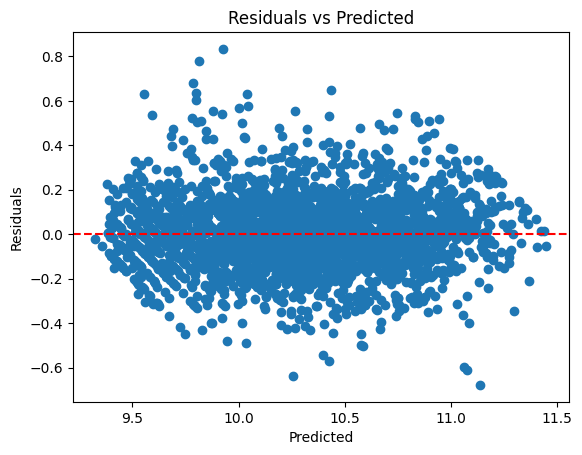

In [ ]:
import matplotlib.pyplot as plt

residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.show()

In [ ]:
residual_std = np.std(residuals)
print(residual_std)

0.15876220209759934


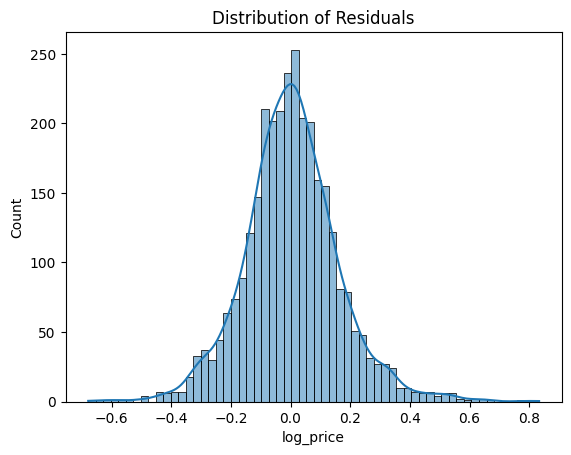

In [ ]:
import seaborn as sns

sns.histplot(residuals, kde=True)
plt.title("Distribution of Residuals")
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.4f}")

RMSE: 0.1588


In [ ]:
print(f"Target mean: {y_test.mean():.4f}")


Target mean: 10.2968


In [ ]:
#RMSE / Target mean
print(f'{rmse/y_test.mean():.4%}')

1.5424%


### RMSE / Target Mean % of 1.5% shows good fit

Test data vs Predicted data to understand model fit

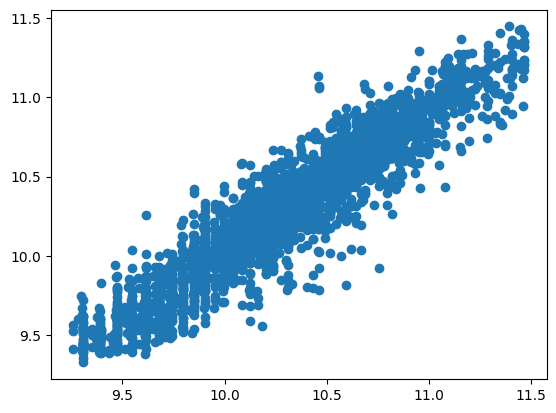

In [ ]:
plt.scatter(y_test, y_pred)
plt.show()

### Trying with randomforest regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# Automatically detect feature types
categorical = X.select_dtypes(include=["object", "category"]).columns.tolist()
numeric = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

print("Categorical:", categorical)
print("Numeric:", numeric)

# Preprocessing
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
    ("num", StandardScaler(), numeric)
])


Categorical: []
Numeric: ['Kilometres', 'doors_int', 'seats_int', 'LitresPer100km', 'used_0_new_1', 'transmission_auto', 'color_black', 'color_white', 'color_gray', 'color_silver', 'color_red', 'fuel_cat_Gasoline', 'fuel_cat_Diesel', 'fuel_cat_Electric', 'fuel_cat_Hybrid', 'brand_cat_Economy', 'brand_cat_Luxury', 'brand_cat_Premium', 'brand_cat_Ultra Luxury', 'cylinders', 'engine_l', 'age_squared', 'Body_type_Other', 'Body_type_SUV', 'Body_type_Sedan', 'Body_type_Wagon', 'Make_Model_cat_economy', 'Make_Model_cat_premium']


In [ ]:

# Pipelines
lasso_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", lasso)
])

rf_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", rf)
])

NameError: name 'lasso' is not defined

In [ ]:
rf=RandomForestRegressor(n_estimators=100,random_state=52)
rf.fit(X_train,y_train)

RandomForestRegressor(random_state=52)

In [ ]:
y_pred_rf=rf.predict(X_test)

In [ ]:
r2_rf=r2_score(y_test,y_pred_rf)
mse_rf=mean_squared_error(y_test,y_pred_rf)
rmse=np.sqrt(mse)

print(f'R2:{r2_rf:.4f}')
print(f'MSE:{mse_rf:.4f}')
print(f'RMSE:{rmse:.4f}')

R2:0.8845
MSE:0.0252
RMSE:0.2143


### Understanding feature importance

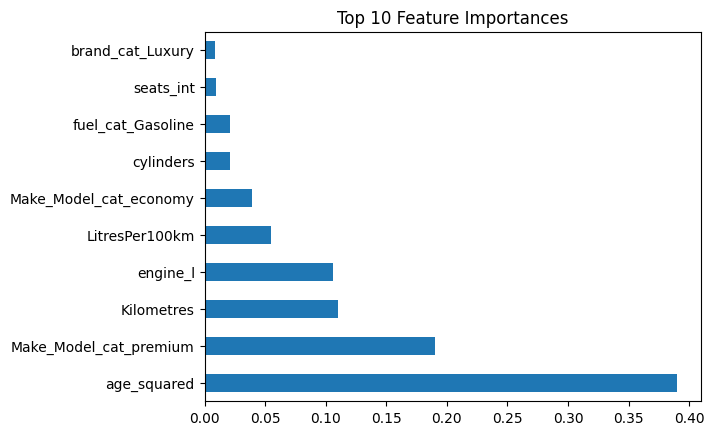

In [ ]:
feature_importance = pd.Series(rf.feature_importances_, index=X.columns)
feature_importance.nlargest(10).plot(kind='barh')
plt.title("Top 10 Feature Importances")
plt.show()

### Randomforest with Best params

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error,r2_score
import numpy as np

# 1. Define the model
rf = RandomForestRegressor(random_state=52)

# 2. Define the grid of hyperparameters to search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# 3. Set up the GridSearchCV
grid_search = GridSearchCV(estimator=rf,
                           param_grid=param_grid,
                           cv=5,             # 5-fold cross-validation
                           scoring='neg_root_mean_squared_error',
                           n_jobs=-1,        # Use all processors
                           verbose=2)

# 4. Fit on training data
grid_search.fit(X_train, y_train)

# 5. Get best parameters and model
print("Best parameters found: ", grid_search.best_params_)

best_model = grid_search.best_estimator_

# 6. Evaluate on test set (optional)
y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
R2=r2_score(y_test,y_pred)
print(f"Test RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters found:  {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Test RMSE: 0.2160
R2: 0.7566


### Saving the model


In [ ]:
import pickle

# Save Lasso model
with open("lasso_model.pkl", "wb") as f:
    pickle.dump(lasso_model, f)

# Save Random Forest model
with open("rf_lasso.pkl", "wb") as f:
    pickle.dump(rf_lasso, f)


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import joblib

In [ ]:
code = """
import streamlit as st
import pickle
import pandas as pd
import numpy as np
from scipy.stats import norm
from datetime import datetime
import matplotlib.pyplot as plt
from brand_dict import brand_dict

# Load the trained model
with open("rf_lasso.pkl", "rb") as f:
    model = pickle.load(f)

# --- Sidebar ---
st.sidebar.markdown("#### About")
st.sidebar.markdown("""
This app was built as part of a data science portfolio.
- **Author**: Gokul GS
- [GitHub Repo](https://github.com/gocool2002/Aus-used-car-predictor)
""")

# --- App Header ---
st.title("🚗 ML-Based Used Car Valuation Tool for the Australian Market")
st.markdown("Kindly fill in the details to get an estimated car price.")

# --- Inputs ---

# 1. Brand
brand_bucket_map = {}
for bucket, brands in brand_dict.items():
    for brand in brands:
        brand_bucket_map[brand] = bucket

input_brand = st.selectbox("Select Brand", sorted(brand_bucket_map.keys()))
brand_bucket = brand_bucket_map.get(input_brand, 'Economy')

brand_dummies = {
    'brand_cat_Economy': 0,
    'brand_cat_Premium': 0,
    'brand_cat_Luxury': 0,
    'brand_cat_Ultra Luxury': 0
}
brand_dummies[f'brand_cat_{brand_bucket}'] = 1

# 2. Year
year = st.slider("Year of Manufacture", min_value=1990, max_value=datetime.now().year, value=2018)
age_squared = (datetime.now().year - year) ** 2

# 3. Kilometres
kilometres = st.number_input("Kilometres Driven", min_value=0, value=50000, step=5000)

# 4. Fuel Type
fuel_type = st.selectbox("Fuel Type", ["Gasoline", "Diesel", "Electric", "Hybrid"])
fuel_dict = {
    'fuel_cat_Gasoline': int(fuel_type == 'Gasoline'),
    'fuel_cat_Diesel': int(fuel_type == 'Diesel'),
    'fuel_cat_Electric': int(fuel_type == 'Electric'),
    'fuel_cat_Hybrid': int(fuel_type == 'Hybrid'),
}

# 5. Fuel Consumption
fuel_eff = st.number_input("Fuel Consumption (L/100km)", min_value=1, value=8, step=1)

# 6. Transmission
transmission = st.radio("Transmission", ["Automatic", "Manual"])
transmission_auto = 1 if transmission == "Automatic" else 0

# 7. Color
color = st.selectbox("Exterior Color", ["Black", "White", "Gray", "Silver", "Red", "Others"])
color_dict = {
    'color_black': int(color == 'Black'),
    'color_white': int(color == 'White'),
    'color_gray': int(color == 'Gray'),
    'color_silver': int(color == 'Silver'),
    'color_red': int(color == 'Red'),
}

# 8. Seats
seats = st.selectbox("Number of Seats", [2, 5, 6, 7], index=1)

# --- Data Preparation ---
input_data = {
    'Kilometres': kilometres,
    'doors_int': 5,  # Default value
    'seats_int': seats,
    'used_0_new_1': 0,
    'LitresPer100km': fuel_eff,
    'transmission_auto': transmission_auto,
    'age_squared': age_squared
}
input_data.update(color_dict)
input_data.update(fuel_dict)
input_data.update(brand_dummies)

required_columns = [
    'Kilometres', 'doors_int', 'seats_int', 'LitresPer100km',
    'used_0_new_1', 'transmission_auto', 'color_black', 'color_white',
    'color_gray', 'color_silver', 'color_red', 'fuel_cat_Gasoline',
    'fuel_cat_Diesel', 'fuel_cat_Electric', 'fuel_cat_Hybrid',
    'brand_cat_Economy', 'brand_cat_Luxury', 'brand_cat_Premium',
    'brand_cat_Ultra Luxury', 'age_squared'
]

for col in required_columns:
    input_data[col] = input_data.get(col, 0)

input_df = pd.DataFrame([input_data])

# --- Prediction ---
if st.button("Predict Price"):
    expected_features = model.feature_names_in_
    input_df = input_df.reindex(columns=expected_features, fill_value=0)

    log_pred = model.predict(input_df)[0]
    residual_std = 0.213
    z_score = norm.ppf(0.95)

    central_price = np.exp(log_pred)
    lower_price = central_price - z_score * np.exp(residual_std)
    upper_price = central_price + z_score * np.exp(residual_std)

    def round_to_1000(x):
        return int(round(x / 1000.0) * 1000)

    central_price_rounded = round_to_1000(central_price)
    lower_price_rounded = round_to_1000(lower_price * 0.9)
    upper_price_rounded = round_to_1000(upper_price * 1.1)

    st.markdown(f"**Predicted Price (Midpoint)**: ${central_price_rounded:,}")
    st.markdown(
        f"""
        <div style='font-family: "sans-serif";'>
            <span style='font-weight: bold; font-size: 20px;'>🔍 Estimated Price Range (90% CI):</span><br>
            <span style='color: #2E8B57; font-weight: 600; font-size: 28px;'>
                ${lower_price_rounded:,} – ${upper_price_rounded:,}
            </span>
        </div>
        """,
        unsafe_allow_html=True
    )

#-----------------------------------------------
# Market data
yoy_price_growth = 4.6  # YoY growth (%) for Australia’s Used Vehicle Price Index (May 2025)
avg_days_to_sell = 49.7  # Average days to sell a used vehicle (April 2025)

# Display metrics
st.metric(
    label="YoY Used Car Price Growth (May 2025)",
    value=f"{yoy_price_growth:.1f}%",
)
st.metric(
    label="Average Days to Sell a Used Vehicle (April 2025)",
    value=f"{avg_days_to_sell:.1f} days",
)

# Display data sources
st.write(
    "Source: Datium Insights – Moody’s Analytics Used Vehicle Price Index (May 2025), "
    "[Economy.com] and AADA April 2025 Used Vehicle Sales Report"
)


#----------------------------------------------------------------
    # Download button for input
    csv = input_df.to_csv(index=False).encode('utf-8')
    st.download_button("📥 Download Input Data", data=csv, file_name="input_features.csv", mime='text/csv')

    # --- Feature Importance ---
    importances = model.feature_importances_
    features = model.feature_names_in_
    sorted_idx = np.argsort(importances)[::-1][:5]

    st.subheader("📊 Top 5 Features")
    fig, ax = plt.subplots()
    ax.barh(range(len(sorted_idx)), importances[sorted_idx][::-1], align='center')
    ax.set_yticks(range(len(sorted_idx)))
    ax.set_yticklabels([features[i] for i in sorted_idx][::-1])
    ax.set_xlabel("Relative Importance")
    st.pyplot(fig)

# --- Model Info ---
with st.expander("ℹ️ Model Info"):
    st.markdown("""
    - **Model**: Random Forest Regressor with Lasso feature selection
    - **R² Score**: 0.86 on test set
    - **Data**: Scraped from Australian car listing sites (pre-cleaned)
    - **Features**: Brand, year, fuel type, color, transmission, etc.
    """)

# ✅ Save to file
with open("app.py", "w") as file:
    file.write(code)


In [ ]:
brand_dict = df.groupby('Brand_Bucket')['Brand'].unique().to_dict()
for bucket, brands in brand_dict.items():
    print(f"{bucket}: {list(brands)}")


Economy: ['Honda', 'Hyundai', 'Nissan', 'Holden', 'Suzuki']
Luxury: ['Land', 'Mercedes-Benz', 'Audi', 'Isuzu', 'Lexus', 'Skoda', 'Porsche', 'GWM']
Premium: ['Renault', 'Toyota', 'Volkswagen', 'BMW', 'Ford', 'Subaru', 'Mitsubishi', 'Jeep', 'Volvo', 'Mazda', 'Kia', 'Mini', 'MG', 'LDV']


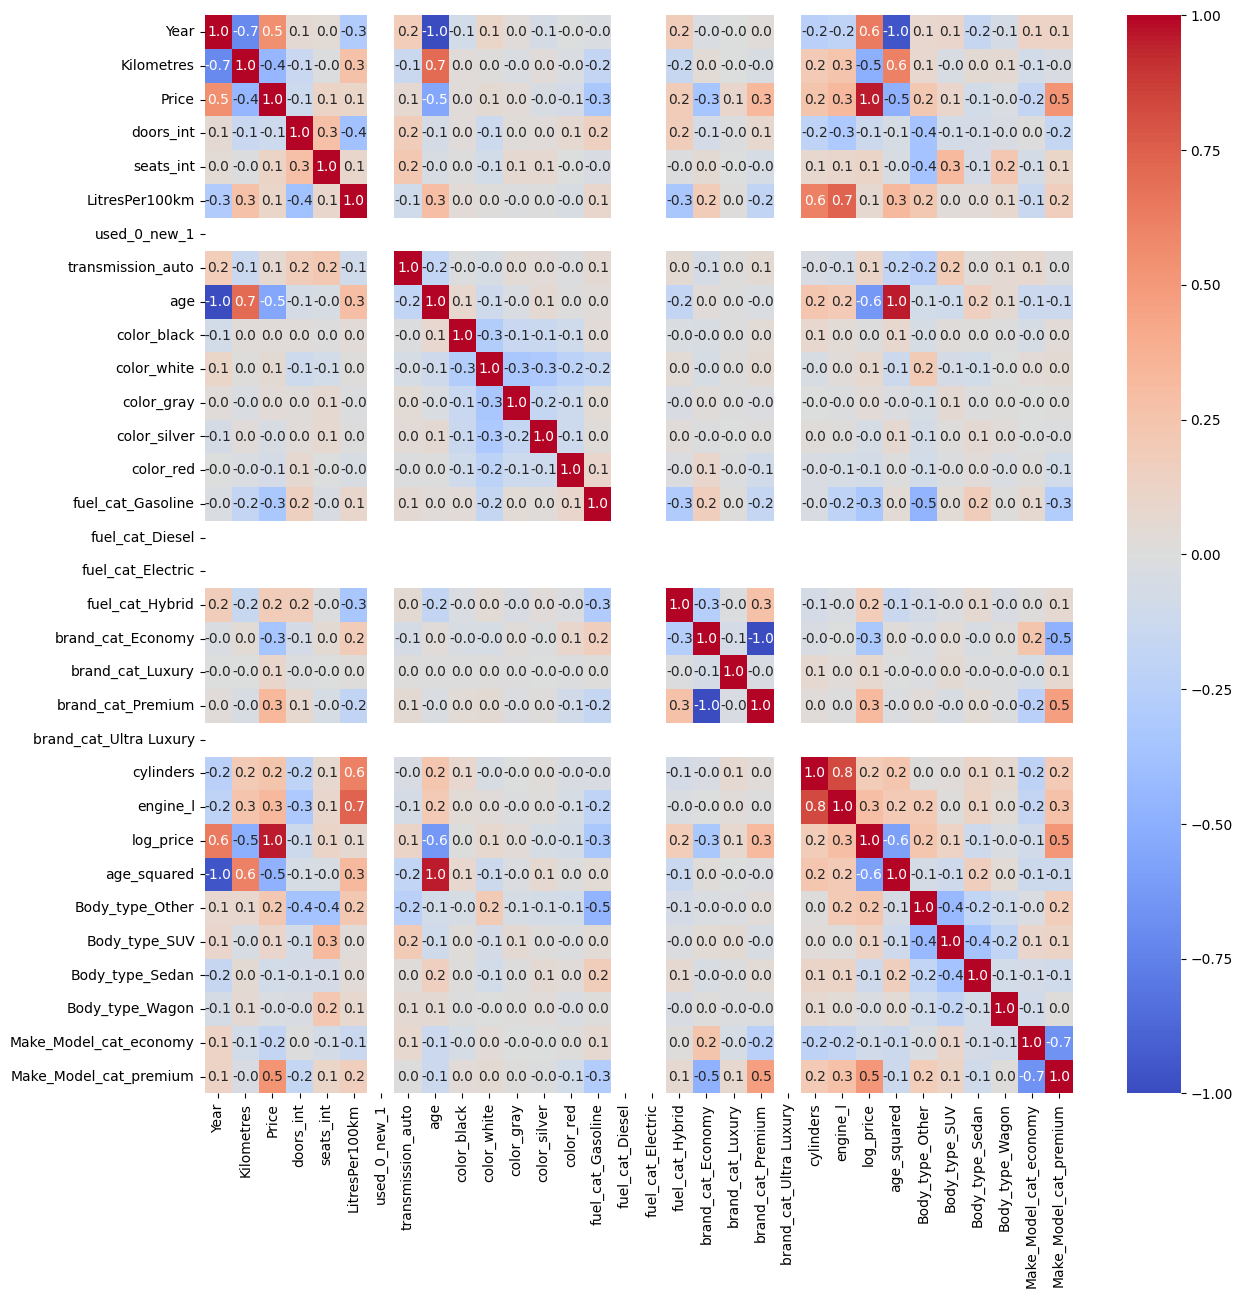

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig,axes=plt.subplots(1,1,figsize=(14,14))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, fmt='.1f',cmap='coolwarm')
plt.show()


<Axes: xlabel='Price', ylabel='age'>

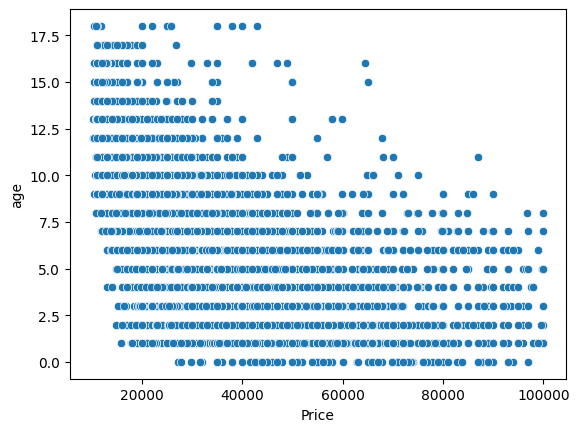

In [ ]:
sns.scatterplot(data=df, x='Price', y='age')

In [ ]:
df.groupby('Brand')['Price'].mean()

,Price
Brand,
Abarth,37490.000000
Alfa,31106.100000
Audi,43385.595092
BMW,39413.042471
Chery,32756.666667
Chrysler,42378.352941
Citroen,19846.285714
Cupra,61880.000000
Dodge,14169.375000


### Initial Observations on output

-Lasso Random forest explains +85% of the variance in pricing (R2 score)

-Trying to give a estimated range with 90% based on log scale gives a very high range which is not useful

-Price increases with Fuel consumption (counter intuitive). Due to luxury and super luxury cars having higher fuel consumption and higher price which is leading to this misrepresentation in the model

-No impact observed due to Transmission type or Condition (Used vs New) due to limited data available for New (can be removed)

-Online sources like carsales.com.au give importance to Engine and Cylinder type (could be included to improve the model)



In [ ]:
df.to_csv("car_data_cleaned.csv", index=False)

In [ ]:
df['Brand'].value_counts()

,count
Brand,
Toyota,1581
Hyundai,966
Mazda,789
Mitsubishi,730
Holden,703
Kia,691
Ford,675
Volkswagen,598
Nissan,594
